In [5]:
import pathlib
import pickle
import random
import re
import unicodedata
import spacy

import tensorflow as tf



In [18]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
from itertools import repeat

In [2]:
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

3423204/3423204 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step
/Users/anushangawimalasena/.keras/datasets/fra.txt


In [7]:
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')

In [15]:
def normalize(line, nlp_en, nlp_fr):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    
    eng, fra = line.split("\t")
    
    eng = nlp_en(eng)
    fra = nlp_fr(fra)

    eng = ' '.join([token.lemma_ for token in eng])
    fra = ' '.join([token.lemma_ for token in fra])

    fra = "[start] " + fra + " [end]"
    return eng, fra

# Slow
# # normalize each line and separate into English and French
# with open(text_file) as fp:
#     text_pairs = [normalize(line, nlp_en, nlp_fr) for line in fp]

# # print some samples
# for _ in range(5):
#     print(random.choice(text_pairs))
 
# with open("text_pairs_2.pickle", "wb") as fp:
#     pickle.dump(text_pairs, fp)

('perhaps he will never become famous .', '[start] peut-être que il ne devenir jamais célèbre . [end]')
('tom check the date .', '[start] tom vérifier le date . [end]')
('you be not suppose to be smoke in here .', '[start] vous ne être pas censé fumer ici . [end]')
('you do not have to explain .', '[start] taire ne être pas obliger de fournir un explication . [end]')
('he live in a big house .', '[start] il voir dans un grand maison . [end]')


In [ ]:
# normalize each line and separate into English and French
with open(text_file) as fp:
    text_input_lines = [line for line in fp]
    len_rep = len(text_input_lines)
    with ThreadPoolExecutor(max_workers = 10) as executor:
        text_pairs = executor.map(normalize, text_input_lines, repeat(nlp_en, len_rep), repeat(nlp_fr, len_rep))

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))
 
with open("text_pairs_2.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

In [22]:
import pickle

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 10322
Total French tokens: 14976
Max English length: 53
Max French length: 65
167130 total pairs


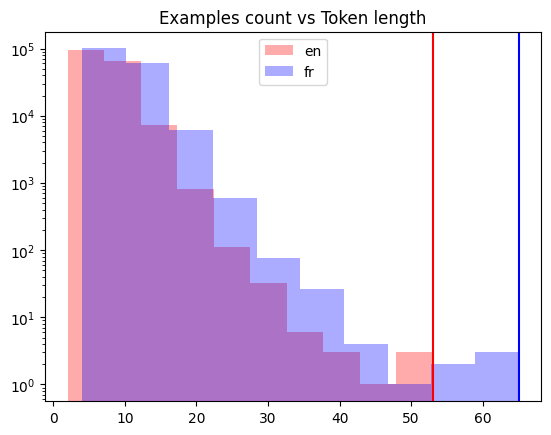

In [24]:
import pickle

import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [23]:
import pickle
import random

from tensorflow.keras.layers import TextVectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

2024-07-14 21:54:26.006680: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-14 21:54:26.006716: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-14 21:54:26.006723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-14 21:54:26.006756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-14 21:54:26.006770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
